# Statistical Methods

        1. Metod: AR(p): Autoregression

Autoregression'da bir zaman serisi kendisinden önceki gecikmeler ile tahmin edilir yaklaşımı ön plandadır.

<p align="center">
  <img src="grafikler/ts_9.png" height=300>
</p>   

        2. Metod: MA(q): Moving Average

Moving Average'da bir zaman serisindeki hatalar ile tahmin edilir yaklaşımı ön plandadır.

<p align="center">
  <img src="grafikler/ts_10.png" height=300>
</p>

        3. Metod: ARMA(p, q): AR(p) + MA(q)

Bu model smoothing metodlardaki SES yöntemine benzemektedir.
 * SES yönteminde bir learning bir de remembering bölümleri vardı.
 * Aşağıdaki formulün AR kısmı learning iken, MA kısmı (hatalardan model kurulan kısmı) remembering bölümüne benzer.
 * Zira remembering de önceki değerleri modelde bulundurma kaygısı yaşıyorduk, burda da önceki verileriden ziyade hatalarımızı modele ekleyerek, hatalarımızı remember ediyoruz.

<p align="center">
  <img src="grafikler/ts_11.png" height=250>
</p>

##### Yukarıdaki modellerin hiç biri trendi ve mevsimselliği modelleyememektedir.

        4. Metod: ARIMA(p, d, q): AR(p) + I(d) + MA(q)

ARIMA modeli trendli veriyi modelleyebilmektedir. Zaman serilerinde seri durağan değil ise tahmin performansının düştüğü varsayımı bulunmaktadır. Dolayısıyla trendli bir veriyi tahmin etmenin daha zor olduğunu söyleyebiliriz. Veriden trendi çıkarmanın bir yolu ise fark almadır. Serinin farkı alındığında trendsiz bir hale gelme eğilimi gösterir.

Fark alma dışında ARMA modeli ile aynıdır. Lakin anlaşılacağı üzere ARIMA, ARMA'dan daha iyi bir modeldir.

<p align="center">
  <img src="grafikler/ts_12.png" height=200>
</p>

ARIMA yöntemi trendi de modelleyebildiği için DES modeline benzemektedir.

## Uygulama Bölümü

In [1]:
# Kütüphanelerimizi import edelim;

import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [2]:
############################
# Veri Seti
############################

# Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
# Period of Record: March 1958 - December 2001

# Aim: Forecasting air pollution in the next month

data = sm.datasets.co2.load_pandas()
data

<class 'statsmodels.datasets.utils.Dataset'>

In [3]:
# Yukarıda modelimiz bir nesne olarak geldi;
# Bir farklılık olarak aşağıdaki gibi bir bağımlı değişken ataması gerçekleştireceğiz;

y = data.data
y

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


In [4]:
# Biz bu haftalık veri setini aylık olarak düzenlemek istiyoruz;
# Aylık formata çevirdikten sonra ortalama alıyoruz;

y = y['co2'].resample('MS').mean()
y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

In [5]:
# Şimdi veri setinde kaç adet eksik değer olduğuna bakalım;

y.isnull().sum()

5

In [6]:
# Burada eksik değerleri veri setindeki bir sonraki değer ile dolduracağız;

y = y.fillna(y.bfill())
y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

In [7]:
# Veri setimizi ikiye bölelim;
# Test ve Train olarak ayıralım;

train = y[:'1997-12-01']
print(len(train))  # 478 ay

# 1998'ilk ayından 2001'in sonuna kadar test set.
test = y['1998-01-01':]
print(len(test))  # 48 ay

478
48


In [8]:
##################################################
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)
##################################################

In [9]:
# Model nesnemizi oluşturalım;

arima_model = ARIMA(train, order=(1, 1, 1)).fit()

# içerisine "order=" argümanına (p, d, q) hiper parametrelerini gönderiyoruz.

In [10]:
# modelin istatistiki çıktısına göz atalım;

print(arima_model.summary())

# Burayı araştıralım !!!

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                  478
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -575.768
Date:                Thu, 09 Mar 2023   AIC                           1157.537
Time:                        13:25:44   BIC                           1170.039
Sample:                    03-01-1958   HQIC                          1162.452
                         - 12-01-1997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5669      0.054     10.586      0.000       0.462       0.672
ma.L1          0.3284      0.062      5.306      0.000       0.207       0.450
sigma2         0.6534      0.050     12.965      0.0

In [11]:
# Önümüzdeki 48 dönemi tahmin edelim;

y_pred = arima_model.forecast(48)
y_pred

1998-01-01    365.558639
1998-02-01    366.300479
1998-03-01    366.721012
1998-04-01    366.959404
1998-05-01    367.094543
1998-06-01    367.171151
1998-07-01    367.214578
1998-08-01    367.239196
1998-09-01    367.253151
1998-10-01    367.261062
1998-11-01    367.265547
1998-12-01    367.268089
1999-01-01    367.269530
1999-02-01    367.270347
1999-03-01    367.270810
1999-04-01    367.271073
1999-05-01    367.271222
1999-06-01    367.271306
1999-07-01    367.271354
1999-08-01    367.271381
1999-09-01    367.271396
1999-10-01    367.271405
1999-11-01    367.271410
1999-12-01    367.271413
2000-01-01    367.271414
2000-02-01    367.271415
2000-03-01    367.271416
2000-04-01    367.271416
2000-05-01    367.271416
2000-06-01    367.271416
2000-07-01    367.271416
2000-08-01    367.271416
2000-09-01    367.271416
2000-10-01    367.271416
2000-11-01    367.271416
2000-12-01    367.271416
2001-01-01    367.271416
2001-02-01    367.271416
2001-03-01    367.271416
2001-04-01    367.271416


In [12]:
# Görselleştirme fonksiyonunu tanımlaylım;

def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

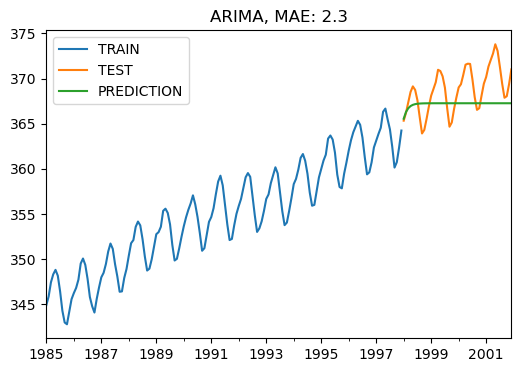

In [13]:
# Tahmin ve gerçek değerlerimizi görselleştirelim;

plot_co2(train, test, y_pred, "ARIMA")

In [14]:
############################
# Hyperparameter Optimization (Model Derecelerini Belirleme)
############################

# İki yaklaşım da aynıdır.

############################
# AIC & BIC İstatistiklerine Göre Model Derecesini Belirleme
############################

Model optimizasyonunu AIC & BIC istatistiklerine göre veya ACF, PACF'ye göre yapabiliriz.

Lakin ACF ve PACF'nin yetersiz olduğu yerler olduğu için biz IC & BIC istatistiklerine göre optimizasyon yapmayı tercih edeceğiz.

ACF ve PACF'nin ne olduğunu bilmiyorsanız, daha detaylı bilgi için;
"https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c" internet sitesinden araştırabilirsiniz.

In [15]:
# Burada hiperparametre kobinasyonları oluşturacağız ve 
# en düşük AIC & BIC istatistiklerini veren hiperparametre kombinasyonunu en iyi hiper parametreler olarak kabul edeceğiz.


# hiper parametrelerimiz tanımlayalım;

p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

# Yukarıda itertool.product ile, hiperparametrelerin olası kombinasyonlarını getirmiş olduk.

In [16]:
# En iyi hiperparametreyi arayacak fonksiyonumuzu tanımlayalım;

def arima_optimizer_aic(train, orders):
    best_aic, best_params = [float("inf"), None]
    for i in orders:
        try:
            arima_model_result = ARIMA(train, order=i).fit()
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, i
            print('ARIMA%s AIC=%.2f' % (i, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

In [17]:
# Hiper parametrelerimizi arayalım;

best_params_aic = arima_optimizer_aic(train, pdq)

ARIMA(0, 0, 0) AIC=3954.01
ARIMA(0, 0, 1) AIC=3312.73
ARIMA(0, 0, 2) AIC=2771.31
ARIMA(0, 0, 3) AIC=2328.74
ARIMA(0, 1, 0) AIC=1523.91
ARIMA(0, 1, 1) AIC=1254.79
ARIMA(0, 1, 2) AIC=1137.97
ARIMA(0, 1, 3) AIC=1094.51
ARIMA(0, 2, 0) AIC=1279.81
ARIMA(0, 2, 1) AIC=1257.89
ARIMA(0, 2, 2) AIC=1247.74
ARIMA(0, 2, 3) AIC=1141.50
ARIMA(0, 3, 0) AIC=1482.91
ARIMA(0, 3, 1) AIC=1286.29
ARIMA(0, 3, 2) AIC=1264.05
ARIMA(0, 3, 3) AIC=1253.48
ARIMA(1, 0, 0) AIC=1536.61
ARIMA(1, 0, 1) AIC=1267.22
ARIMA(1, 0, 2) AIC=1149.98
ARIMA(1, 0, 3) AIC=1105.72
ARIMA(1, 1, 0) AIC=1207.78
ARIMA(1, 1, 1) AIC=1157.54
ARIMA(1, 1, 2) AIC=1113.98
ARIMA(1, 1, 3) AIC=1095.90
ARIMA(1, 2, 0) AIC=1256.05
ARIMA(1, 2, 1) AIC=1257.80
ARIMA(1, 2, 2) AIC=1161.11
ARIMA(1, 2, 3) AIC=1117.55
ARIMA(1, 3, 0) AIC=1418.84
ARIMA(1, 3, 1) AIC=1262.06
ARIMA(1, 3, 2) AIC=1263.84
ARIMA(1, 3, 3) AIC=1253.50
ARIMA(2, 0, 0) AIC=1217.86
ARIMA(2, 0, 1) AIC=1168.38
ARIMA(2, 0, 2) AIC=1124.96
ARIMA(2, 0, 3) AIC=1106.92
ARIMA(2, 1, 0) AIC=1103.53
A

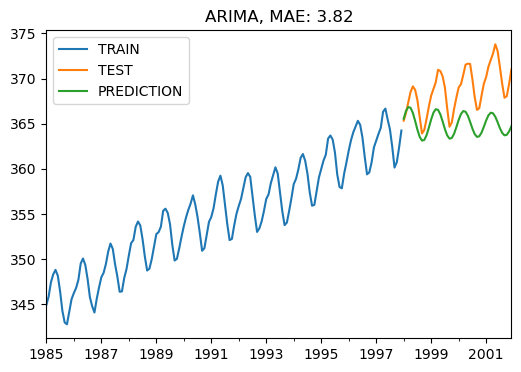

In [18]:
# Final modelini kuralım;
arima_model = ARIMA(train, order = (2,1,3)).fit()

# Önümüzdeki 48 dönem için tahmin işleminde bulunalım;
y_pred = arima_model.forecast(48)

# Bu tahminleri dataFrame'e kaydedelim;
y_pred = pd.Series(y_pred, index=test.index)

# dataFrame'e kaydediyoruz, zira görselleştirme fonksiyonumuz ya numpy array'ini ya da dataframe'i algılayabiliyor.
plot_co2(train, test, y_pred, "ARIMA")

In [19]:
##################################################
# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)
##################################################

#### SARIMA Modeli

<p align="left">
  <img src="grafikler/ts_13.png" height=350>
</p>

### Veri Türüne Göre Kullanılacak Tahmin Yöntemleri

<p align="center">
  <img src="grafikler/ts_14.png" height=200>
</p>

In [20]:
# SARIMA modelimizi oluşturalım;

model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))

# Modelimize verilerimizi fit edelim;

sarima_model = model.fit(disp=0)

# "disp=0" argümanı ile model çıktılarını görmek istemediğimizi ifade ediyoruz.
# Dilersenizi argümanı silerek aradaki farkı görebilirisiniz.

In [21]:
# Önümüzdeki 48 dönemi forecast edelim;

y_pred_test = sarima_model.get_forecast(steps=48)
y_pred_test
# Burada forecast için ".get_forecast()" metodunu kullanıyoruz !!!

    Görüldüğü gibi forecast bir nesne olarak kaydedilmiş bu nesne içerisinden bizim tahmin değerlerini çağırmamız gerekmektedir.

In [22]:
# Tahmin değerlerimizi çağıralım;

y_pred = y_pred_test.predicted_mean
y_pred

1998-01-01    365.160364
1998-02-01    365.156968
1998-03-01    365.153572
1998-04-01    365.150176
1998-05-01    365.146780
1998-06-01    365.143384
1998-07-01    365.139988
1998-08-01    365.136592
1998-09-01    365.133196
1998-10-01    365.129800
1998-11-01    365.126404
1998-12-01    365.123009
1999-01-01    365.119613
1999-02-01    365.116217
1999-03-01    365.112821
1999-04-01    365.109426
1999-05-01    365.106030
1999-06-01    365.102634
1999-07-01    365.099239
1999-08-01    365.095843
1999-09-01    365.092448
1999-10-01    365.089052
1999-11-01    365.085657
1999-12-01    365.082261
2000-01-01    365.078866
2000-02-01    365.075471
2000-03-01    365.072075
2000-04-01    365.068680
2000-05-01    365.065285
2000-06-01    365.061890
2000-07-01    365.058494
2000-08-01    365.055099
2000-09-01    365.051704
2000-10-01    365.048309
2000-11-01    365.044914
2000-12-01    365.041519
2001-01-01    365.038124
2001-02-01    365.034729
2001-03-01    365.031334
2001-04-01    365.027939


In [23]:
# Bu ifadayi pandas serisine çavirelim; (görselleştirme fonksiyonumuzu çalıştırabilmek için)

y_pred = pd.Series(y_pred, index=test.index)

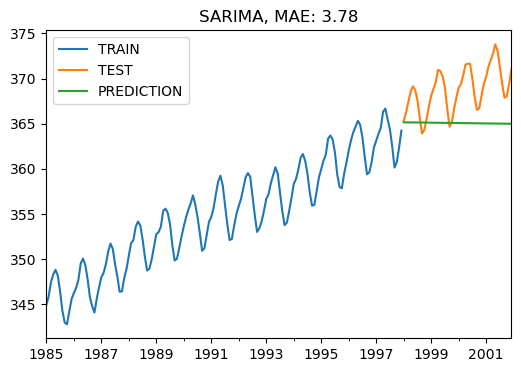

In [24]:
# Grafiğimizi oluşturalım;

plot_co2(train, test, y_pred, "SARIMA")


    Oldukça kötü bir tahmin yapmışız gibi gözüküyor. Çünkü daha hiper parametreleri optimize etmedik !!!

In [25]:
############################
# Hyperparameter Optimization (Model Derecelerini Belirleme)
############################

In [26]:
# p, d, q hiper parametrelerini oluşturalım;
p = d = q = range(0, 2)

# Olası kombinasyonlarını oluşturmak için itertools kullanıyoruz;
pdq = list(itertools.product(p, d, q))

In [27]:
# SARIMA modelinde bir de mevsimsellik vardı, bu sebeple mevsimsel P, D, Q sayılarını da belirlememiz gerekiyor;

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [28]:
# Tanımladığımız hiper parametrelerin içerisinden en iyisini bulacak bir fonksiyon tanımlayalım;

def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [38]:
# En iyi parametrelerimizi arayalım;
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6922.606550808509
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6318.305219680602
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1643.9996657880379
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1428.2938925354604
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4.0
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1641.0630561793785
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1205.025400970622
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:973.2077276745171
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6269.190364743679
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5663.567928197962
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1229.8447515658104
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1126.5843176942813
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1467.6453815719299
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1414.1611034075604
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1008.1602685069556
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:767.633284049758
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1523.9134546907358
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1154.74361990421

In [39]:
# En iyi hiper parametrelerimize bakalım;
print(best_order, best_seasonal_order)

(0, 0, 0) (1, 0, 0, 12)


In [40]:
# Final modelimizi oluşturalım;

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

In [42]:
# Önümüzdeki 48 dönemi tahmin edelim;
y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean

# Tahmin değerlerimizi pandas serisi olarak kaydedelim;
y_pred = pd.Series(y_pred, index=test.index)

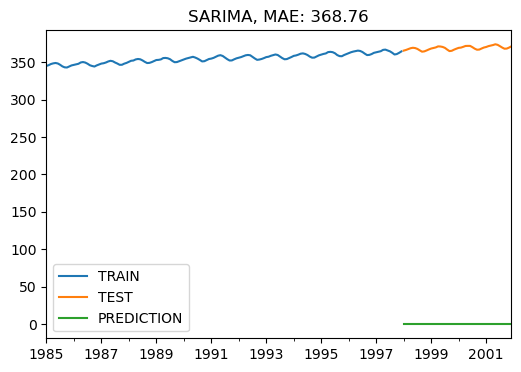

In [43]:
# Grafiğimizi çizdirelim;

plot_co2(train, test, y_pred, "SARIMA")

    Yukarıda bir sorunla karşılaşıyoruz; sorunu çzömek için çalışmalarımız devam ediyor :)

In [45]:
# AIC'si ikinci en düşük hiper parametreleri getiriyoruz;

best_order = (1, 1, 1)
best_seasonal_order = (0, 1, 1, 12)

In [46]:
# Final modelimizi yukarıda elle tanınmladığımız parametreler üzeriden oluşturalım;

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

In [47]:
# Önümüzdeki 48 dönemi tahmin edelim;
y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean

# Tahmin değerlerimizi pandas serisi olarak kaydedelim;
y_pred = pd.Series(y_pred, index=test.index)

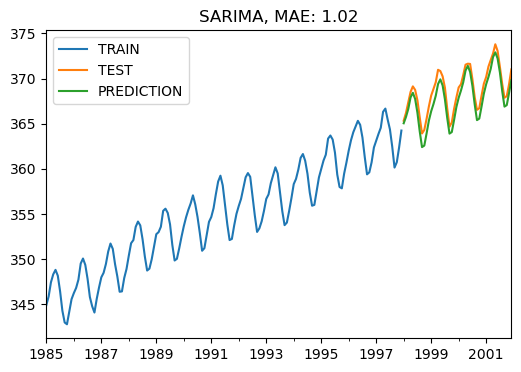

In [48]:
# Grafiğimizi çizdirelim;

plot_co2(train, test, y_pred, "SARIMA")

In [52]:
##################################################
# BONUS: MAE'ye Göre SARIMA Optimizasyonu
##################################################

In [53]:
# Model hiper parametrelerimizi tanımladık;

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [54]:
# MAE için optimise edecek bir fonksiyon tanımlayalım;

def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=48)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

In [55]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:368.7634375
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:324.1790915674028
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:5.063020833333329
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:4.803324372943795
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:368.7634375
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:4.868816038820042
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:3.3237249240677222
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:1.5279722987925481
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:364.9178691427639
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:320.4050599214179
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:4.985339497879218
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:4.765306164494643
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:4.923773150472248
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:4.695621996368506
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:3.674156856496366
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:1.5667165800947984
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:4.526979166666664
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:3.9315401446719833


In [56]:
# Final modelimizi kuralım;

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

# Final modeli üzerinden önümüzdeki 48 döneme yönelik tahminde bulunalım;
y_pred_test = sarima_final_model.get_forecast(steps=48)

# Tahmin değerlerimizi getirelim;
y_pred = y_pred_test.predicted_mean

# Tahmin değerlerini pandas series'i şeklinde kaydedelim;
y_pred = pd.Series(y_pred, index=test.index)

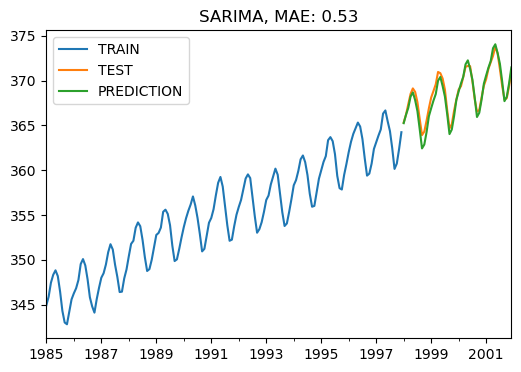

In [57]:
# Grafiğimizi çizdirelim;
plot_co2(train, test, y_pred, "SARIMA")

        ÇOK ÖNEMLİ NOT !!!
    Burada modellerimizi istatistiki çıktılar üzerinden değil de en az hatayı verecek hiper parametreler üzerinden kurmamız gerekir.

# Final Model (Bütün denemelerin Finali)

Bizle daha önceden veri setini test ve train olarak ikiye bölmüştük. Train veri setinde veriyi eğitip test'de hatalarımıza bakmıştık. Daha sonra ise en düşük hatayı verecek şekilde hiper paramere optimizasyonu yapmıştık.

Şimdi ise belirlediğimiz optimum hiper parametre ve verinin tamamı ile modelimizi eğitip sonrasında, artık bilmediğimiz sonraki (genelde bir sonraki olabilir) dönemlere ilişkin tahminlerde bulunacağız.

In [58]:
# Modelimizi oluşturalım;
model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal_order)

# Modele verimizi fit edelim;
sarima_final_model = model.fit(disp=0)

In [62]:
y

# Aşağıda görüldüğü üzere veri "2001-12-01" de bitiyor.

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

In [59]:
# Sonraki dönemi tahmin edelim;
future_predict = sarima_final_model.get_forecast(steps=1)
future_predict = future_predict.predicted_mean
future_predict

2002-01-01    371.930531
Freq: MS, dtype: float64